In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
from tensorflow import keras
from tensorflow.keras.layers import Conv1D,MaxPool1D,BatchNormalization,Bidirectional,LSTM,Flatten,Input,Dense
from keras import Model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report , confusion_matrix
from keras.utils.np_utils import to_categorical
import warnings
warnings.filterwarnings('ignore')


In [2]:
train_dataset = 'C:/Users/mahfo/Downloads/archive (4)/mitbih_train.csv'
test_dataset = 'C:/Users/mahfo/Downloads/archive (4)/mitbih_test.csv'

train_df = pd.read_csv (train_dataset,header=None)
test_df = pd.read_csv (test_dataset,header=None)
print ('infromation about train data')
train_df.info()
print ('\n infromation about test data')
test_df.info()


infromation about train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB

 infromation about test data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


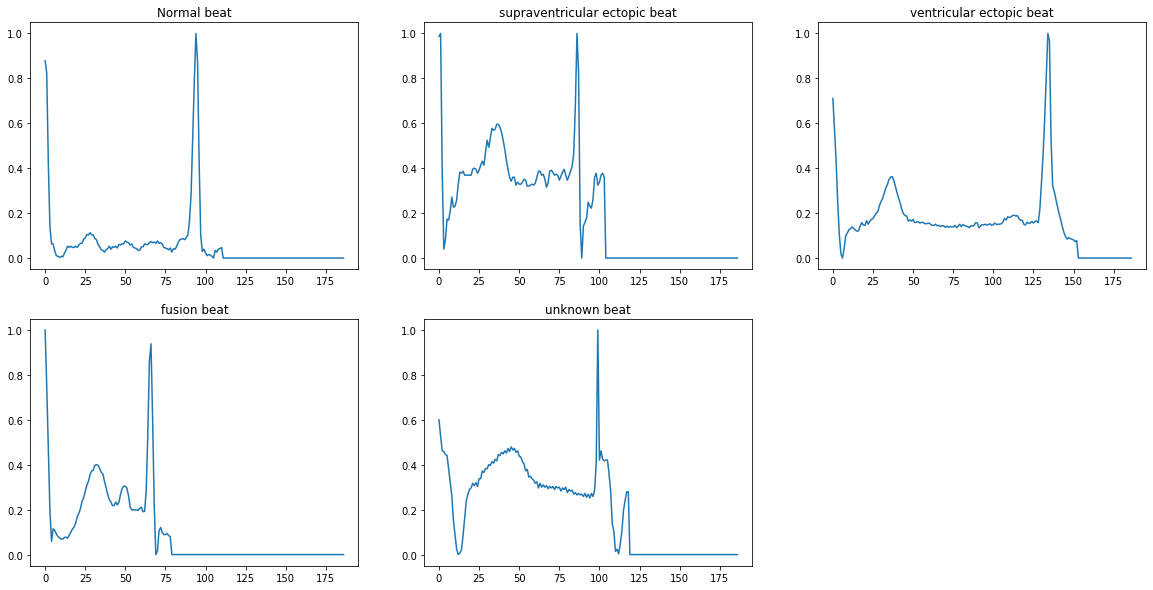

In [3]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.plot (range (0,187), (train_df.loc [train_df[187] ==0]).sample(1).iloc [:,:-1].values[0] )
plt.title ('Normal beat')

plt.subplot(2,3,2)
plt.plot ( (train_df.loc [train_df[187] ==1]).sample(1).iloc [:,:-1].values[0])
plt.title ('supraventricular ectopic beat')

plt.subplot(2,3,3)
plt.plot ( (train_df.loc [train_df[187] ==2]).sample(1).iloc [:,:-1].values[0])
plt.title ('ventricular ectopic beat')

plt.subplot(2,3,4)
plt.plot ( (train_df.loc [train_df[187] ==3]).sample(1).iloc [:,:-1].values[0])
plt.title ('fusion beat')

plt.subplot(2,3,5)
plt.plot ( (train_df.loc [train_df[187] ==4]).sample(1).iloc [:,:-1].values[0])
plt.title ('unknown beat')

plt.show()

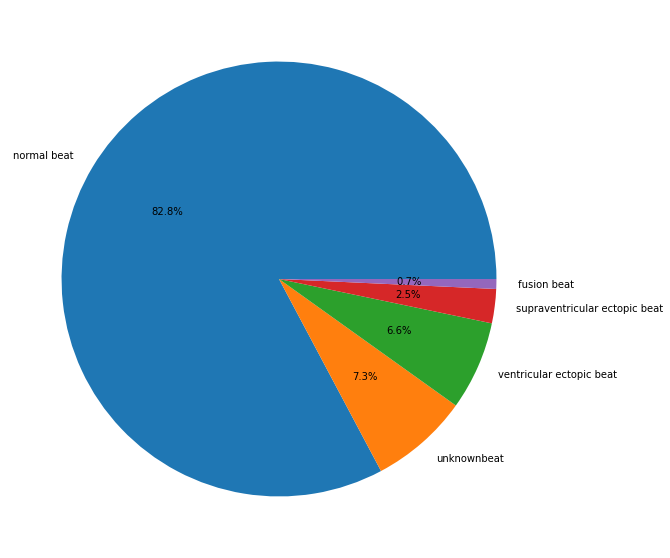

In [4]:
beats = ['normal beat' ,'unknownbeat','ventricular ectopic beat' , 'supraventricular ectopic beat' , 'fusion beat' ]
plt.figure(figsize=(20,10))
plt.pie (train_df [187].value_counts().values,labels = beats,autopct='%1.1f%%')
plt.show()

In [5]:
smote = SMOTE (sampling_strategy='all',random_state=42)
x =train_df.drop (columns =187)
y = train_df[187]
x,y = smote.fit_resample (x,y)
train_df = pd.concat([x,y],axis = 1)

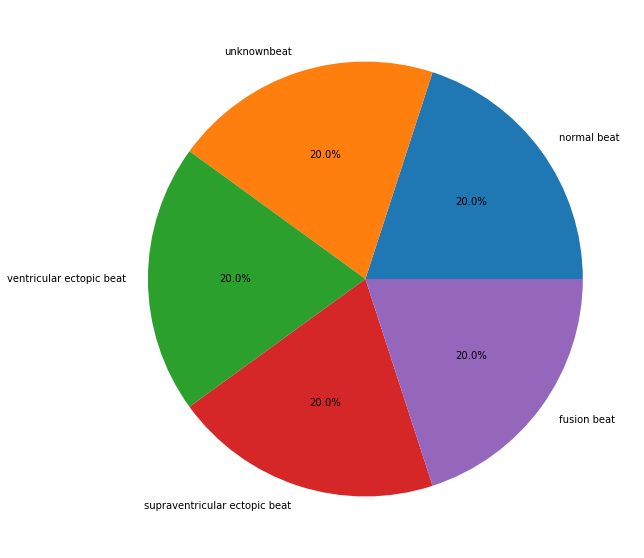

In [8]:
plt.figure(figsize=(20,10))
plt.pie (train_df [187].value_counts().values,labels = beats,autopct='%1.1f%%')
plt.show()

In [6]:
train_df = train_df.sample (frac =1) # randomize dataset

X_train = train_df.iloc [:,:-1].values
X_train = np.expand_dims(X_train,axis = -1)
y_train = to_categorical (train_df.iloc [:,-1].values)

X_test = test_df.iloc [:,:-1].values
X_test = np.expand_dims(X_test,axis = -1)
y_test = to_categorical (test_df.iloc [:,-1].values)

In [10]:
inputs = Input (shape = (X_train.shape[1],1))
x = Conv1D(filters=64, kernel_size=7, padding="causal",activation="relu")(inputs)
x = BatchNormalization()(x)
x = MaxPool1D(3)(x)
x = Conv1D(filters=64, kernel_size=5, padding="causal",activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool1D(3)(x)
'''x = Conv1D(filters=64, kernel_size=3, padding="causal",activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool1D(2)(x)'''
x = keras.layers.Bidirectional( keras.layers.LSTM(64, return_sequences=True))(x)
x = keras.layers.Bidirectional( keras.layers.LSTM(32))(x)
x = Dense (16,activation = 'relu')(x)
x = Dense(5,activation = 'softmax') (x)

model = Model([inputs], outputs=x)
model.summary()
callbacks = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights = True,verbose = 1),
             ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss='CategoricalCrossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4),metrics=["accuracy"])
history = model.fit (X_train, y_train,epochs=50,batch_size=32,callbacks = [callbacks],validation_data=(X_test,y_test))
model.load_weights('model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 187, 64)           512       
                                                                 
 batch_normalization (BatchN  (None, 187, 64)          256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 62, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 64)            20544     
                                                                 
 batch_normalization_1 (Batc  (None, 62, 64)           256   

KeyboardInterrupt: 

In [21]:
# Dropout is a powerful technique for combating overfitting in your LSTM models 
from keras.layers import *
embedding_vecor_length=187
model = Sequential()
model.add(Embedding(1000, embedding_vecor_length, input_length=187))
model.add(LSTM(50, dropout=0.001, recurrent_dropout=0.001))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 187, 187)          187000    
                                                                 
 lstm_6 (LSTM)               (None, 50)                47600     
                                                                 
 dense_5 (Dense)             (None, 5)                 255       
                                                                 
Total params: 234,855
Trainable params: 234,855
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
 3686/11324 [========>.....................] - ETA: 28:03 - loss: 1.6097 - accuracy: 0.2003

KeyboardInterrupt: 